# 대회
>https://bd.kma.go.kr/contest/info_01.do

>240371

>0704

* 개선을 위한 방법
1. 마지막엔 test을 나누지말고 그냥 전부 train 시켜버린다
2. 쓸데 없는 열을 버려본다?
3. 앙상블 모델을 써볼까?

* 코드 순서
1. df에서 지역별로 5개 나눠서 각자 자기꺼(e, 남해)만 출력 후 아래의 전처리 동일하게 진행
2. 문자형식은 수치화하기
3. 선형보간법으로 독립변수 결측값 대체
4. re(0, 1) 결측값 대체 방법 선정 -> 직전값
5. 선형보간법으로 독립변수 이상치 대체
6. 정규화 방법 선정 -> 월별 계절성을 반영한 min-max scaler
7. target(vis1, class) 결측값 대체 방법 선정 -> random forest (seed: 123)
8. 파생변수 생성
9. lstm 적용 (sequence = 6) # 1시간 단위로 설정
10. 가중치 조절

In [1]:
# 샘플링
# 시퀀스 30에서 늘리기
# class 결측치 채워보기

# 1. 데이터 불러오기 및 파악

In [2]:
import pandas as pd
import numpy as np
import joblib

# 데스크탑
df = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

# 노트북
# df = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

In [3]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

In [4]:
df.head()

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
1,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
2,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
3,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4
4,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4
5,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3156459 entries, 1 to 3156459
Data columns (total 15 columns):
 #   Column    Dtype  
---  ------    -----  
 0   year      object 
 1   month     int64  
 2   day       int64  
 3   time      int64  
 4   minute    int64  
 5   stn_id    object 
 6   ws10_deg  float64
 7   ws10_ms   float64
 8   ta        float64
 9   re        float64
 10  hm        float64
 11  sun10     float64
 12  ts        float64
 13  vis1      int64  
 14  class     int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 385.3+ MB


In [6]:
df.describe()

,month,day,time,minute,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
count,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06
mean,6.521931e+00,1.573276e+01,1.150007e+01,2.500016e+01,1.852152e+02,1.999417e+00,1.328812e+01,-4.298995e-01,6.667729e+01,-1.288869e+00,1.282955e+01,1.963548e+04,3.246275e+00
std,3.448969e+00,8.801320e+00,6.922149e+00,1.707819e+01,1.072184e+02,4.721616e+00,1.100537e+01,6.929268e+00,2.173623e+01,1.171355e+01,2.257327e+01,1.206407e+04,8.668957e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.900000e+01,-9.900000e+01
25%,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,8.470000e+01,9.000000e-01,5.500000e+00,0.000000e+00,5.130000e+01,0.000000e+00,5.100000e+00,1.229700e+04,4.000000e+00
50%,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,2.094000e+02,1.800000e+00,1.430000e+01,0.000000e+00,6.870000e+01,0.000000e+00,1.570000e+01,2.000000e+04,4.000000e+00
75%,1.000000e+01,2.300000e+01,1.800000e+01,4.000000e+01,2.769000e+02,3.000000e+00,2.200000e+01,0.000000e+00,8.470000e+01,1.600000e-01,2.430000e+01,2.000000e+04,4.000000e+00
max,1.200000e+01,3.100000e+01,2.300000e+01,5.000000e+01,3.600000e+02,2.250000e+01,3.780000e+01,1.000000e+00,1.000000e+02,2.687000e+01,7.010000e+01,6.052500e+04,4.000000e+00


In [7]:
df.columns

Index(['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg',
       'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1', 'class'],
      dtype='object')

In [8]:
# # 시간
# df['year'].value_counts() # 년도
# df['month'].value_counts() # 월
# df['day'].value_counts() # 일
# df['time'].value_counts() # 시간(0~23)
# df['minute'].value_counts() # 분(10분 단위)
# df['stn_id'].value_counts() # 지점 번호

# -99 있음
# df['ws10_deg'].value_counts() # 10분 평균 풍향, 단위 : deg
# df['ws10_ms'].value_counts() # 10분 평균 풍속, 단위 : m/s
# df['ta'].value_counts() # 1분 평균 기온 10분 주기, 단위 : C
# df['re'].value_counts() # 강수 유무(0:무강수, 1:강수)
# df['hm'].value_counts() # 1분 평균 상대 습도 10분 주기, 단위 : %
# df['sun10'].value_counts() # 1분 일사량 10분 단위 합계, 단위 : MJ
# df['ts'].value_counts() # 1분 평균 지면온도 10분 주기, 단위 : C
# df['vis1'].value_counts() # 1분 평균 시정 10분 주기, 단위 : C(test데이터 셋엔 없음)
# df['class'].value_counts() # 시정 구간

# 2. 문자열 데이터 정리

## 2-1. year열 I,J,K 순으로 0,1,2로 맵핑

In [9]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'].value_counts()
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})

## 2-2. 20개 지점을 5개의 지역으로 수치화

In [10]:
df['region'] = df['stn_id'].str[0]

# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# region을 데이터 분석에 활용할 수 있도록 원-핫 인코딩
df = pd.get_dummies(df, columns=['region'], prefix='region')
df = pd.get_dummies(df, columns=['stn_id'], prefix='region')

In [11]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region_0,region_1,region_2,region_3,region_4
1,0,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4,1,0,0,0,0
2,0,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4,1,0,0,0,0
3,0,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4,1,0,0,0,0
4,0,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4,1,0,0,0,0
5,0,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4,0,0,0,0,1
3156456,2,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4,0,0,0,0,1
3156457,2,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4,0,0,0,0,1
3156458,2,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4,0,0,0,0,1


# 3. 결측치 처리

## 3-1.독립변수 결측치 처리

In [12]:
# # 방법1 : -99.9를 전부 제거
# # -99.9를 다 날렸을 때 (315만개중에 15만개로 손실)
# df1 = df1[(df1['ws10_deg'] != -99.9) & (df1['ws10_ms'] != -99.9) & (df1['ta'] != -99.9) & (df1['re'] != -99.9) & (df1['hm'] != -99.9) & (df1['sun10'] != -99.9) & (df1['ts'] != -99.9)]
# print(df1.shape)
# # (2994850, 15)

# # 확인용
# # # -99.9를 다 날렸을 때 (13만개 손실, 그중 413개만이 class가 4가 아님, 0.0002%라 그냥 버려도 될듯)
# # df10 = df1.copy()
# # df12 = df10[(df10['ws10_deg'] == -99.9) | (df10['ws10_ms'] == -99.9) | (df10['ta'] == -99.9) | (df10['re'] == -99.9) | (df10['hm'] == -99.9) | (df10['sun10'] == -99.9) | (df10['ts'] == -99.9)]
# # print(df12.shape)
# # print(df12[(df12['class']!=4)].shape)

In [13]:
# 방법2 : -99.9를 NA 처리후 선형보간법
# df에서 변수들 -99 NA처리
# 변환할 열 리스트
numeric_cols = ['stn_id', 'ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[numeric_cols] = df[numeric_cols].replace(-99.9, np.nan)

# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
region_0    0
region_1    0
region_2    0
region_3    0
region_4    0
dtype: int64


In [14]:
# 'fog_train.vis1'이나 'fog_train.class' 열의 값이 -99.9인 행을 제거합니다.(315만개중에 2만개 손실)
# df1은 class -99를 제거했을 떄의 임시 데이터
df1 = df[(df['vis1'] != -99) & (df['class'] != -99)]
print(df.shape)
print(df1.shape)

(3156459, 20)
(3133943, 20)


In [15]:
df1 = df[(df['vis1'] != -99) & (df['class'] != -99)]
df2 = df[(df['vis1'] != -99)]
df3 = df[(df['vis1'] != -99)]
print(df1.shape)
print(df2.shape)
print(df3.shape)

(3133943, 20)
(3133943, 20)
(3133943, 20)


In [16]:
# 데이터 비율 (0.01%, 1:99)
print(df1[(df1['class']!=4)].shape)
print(df1[(df1['class']==4)].shape)

(32134, 20)
(3101809, 20)


In [17]:
df
df['class'].value_counts()
df['stn_id'].value_counts()

AA    157823
AB    157823
EB    157823
EA    157823
DC    157823
DB    157823
DA    157823
CB    157823
CA    157823
BD    157823
BC    157823
BB    157823
BA    157823
AH    157823
AG    157823
AF    157823
AE    157823
AD    157823
AC    157823
EC    157822
Name: stn_id, dtype: int64

# 4. 이상치 처리

## 4-1. 시간과 re열, target를 제외한 나머지의 이상치 탐지 + 대체
- Boxplot 사용(시각화)  
- 수정된 Z-score 사용(이상치 탐지)  
- 직전값을 대체

### 4-1-1. 이상치 대체 전 시각화(Boxplot)

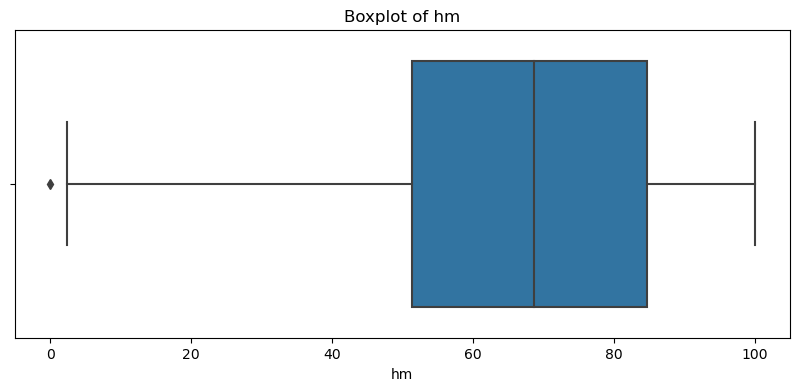

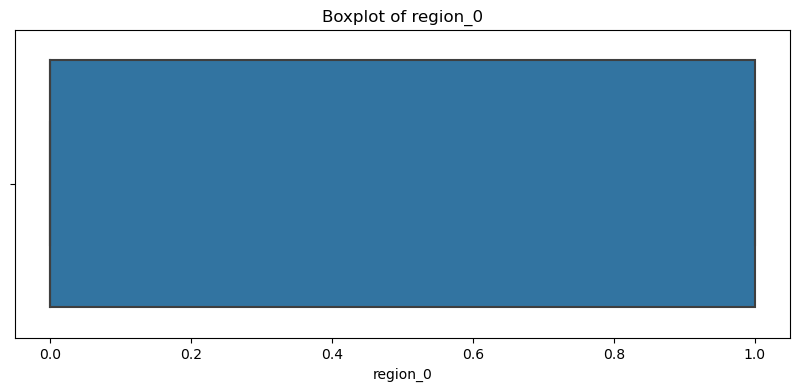

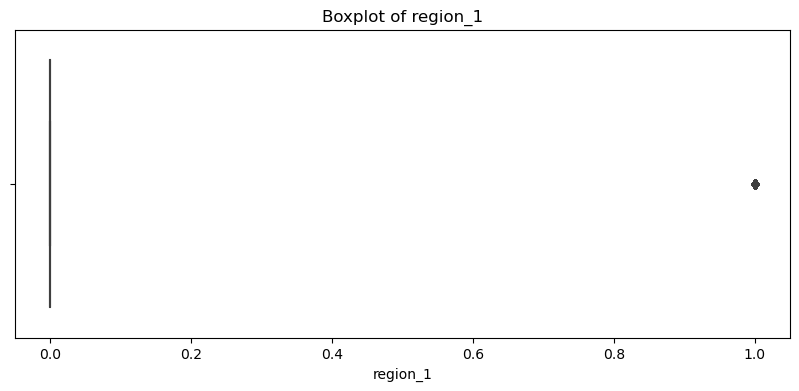

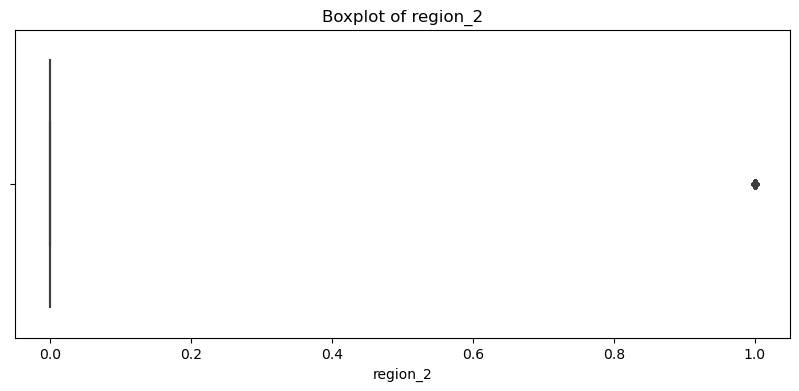

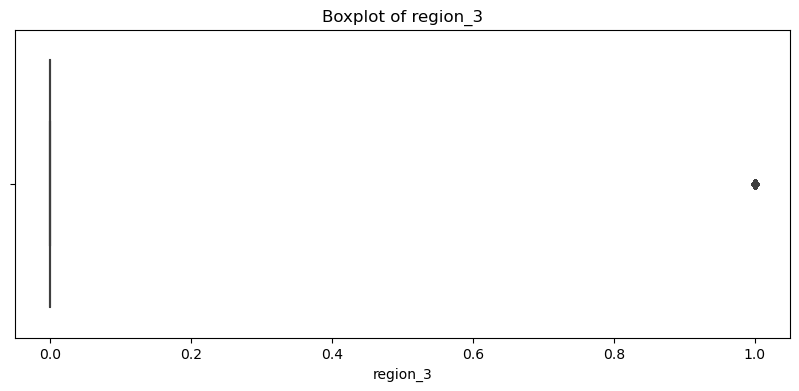

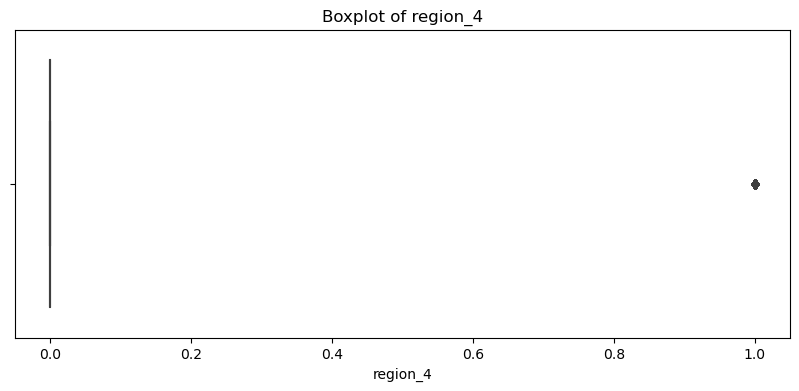

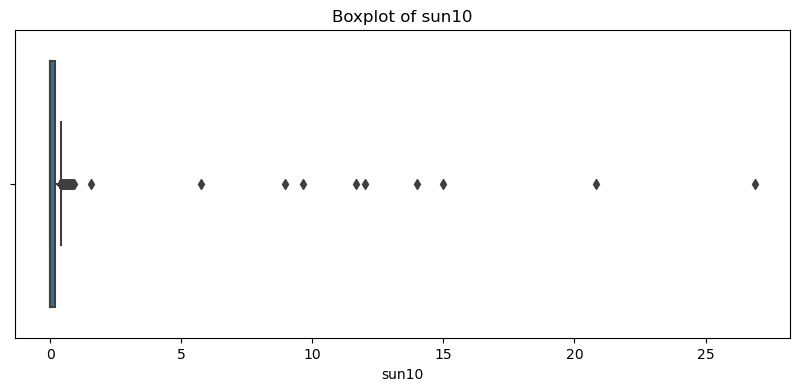

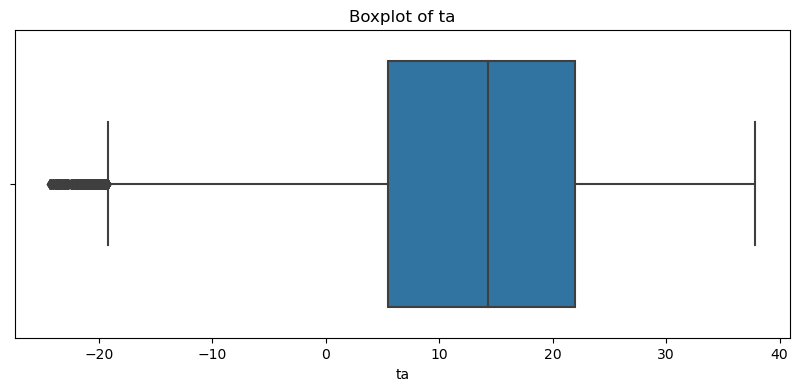

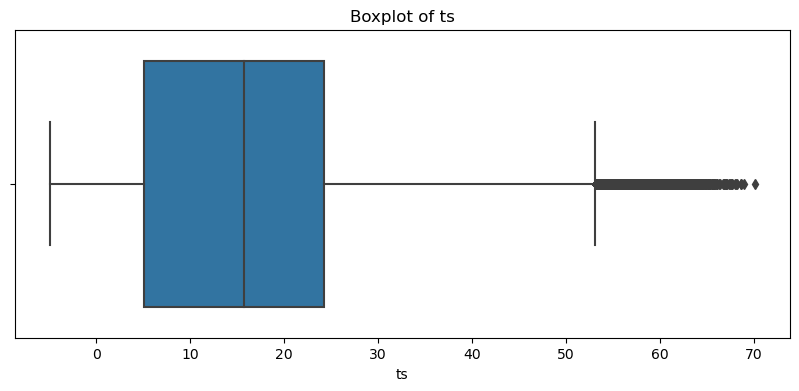

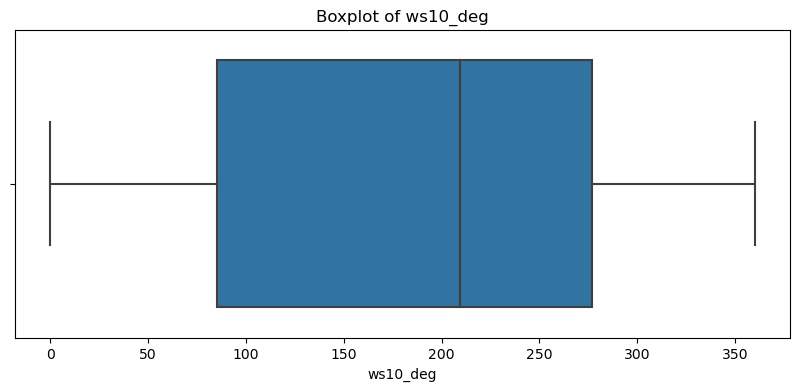

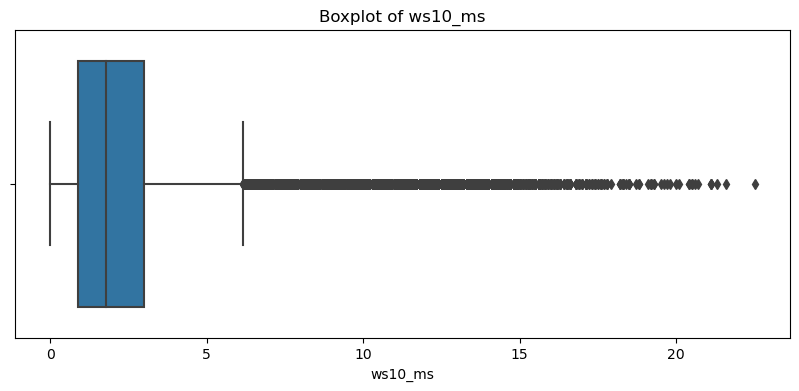

In [18]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 이상치 처리가 필요한 열들 features
features = df.columns.difference(['year', 'month', 'day', 'time', 're', 'stn_id', 'minute', 'vis1', 'class'])

# 이상치 시각화
for feature in features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [19]:
# 오래 걸림 pass
'''
# 추가 
# 정규분포 sun10열
plt.figure(figsize=(10, 6))
sns.histplot(df['sun10'], kde=True, stat="density", linewidth=0)
plt.title('Distribution of sun10')
plt.xlabel('sun10')
plt.ylabel('Density')

# 정규분포 곡선 추가
mean = df['sun10'].mean()
std = df['sun10'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)

plt.show()
'''

'\n# 추가 \n# 정규분포 sun10열\nplt.figure(figsize=(10, 6))\nsns.histplot(df[\'sun10\'], kde=True, stat="density", linewidth=0)\nplt.title(\'Distribution of sun10\')\nplt.xlabel(\'sun10\')\nplt.ylabel(\'Density\')\n\n# 정규분포 곡선 추가\nmean = df[\'sun10\'].mean()\nstd = df[\'sun10\'].std()\nxmin, xmax = plt.xlim()\nx = np.linspace(xmin, xmax, 100)\np = np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))\nplt.plot(x, p, \'k\', linewidth=2)\n\nplt.show()\n'

### 4-1-2. 이상치 탐지(수정된 Z-score)

**수정된 Z-score**

**장점**
1. 비정규성 대응: 기존의 z-score가 정규 분포를 가정하는 반면, 수정된 z-score는 비정규성에 대응하여 더욱 강건하게 이상치를 탐지합니다.
2. 중위수와 MAD 사용: 평균과 표준 편차 대신 중위수와 MAD를 사용하므로 이상치에 민감하지 않고 강력한 방법입니다.
3. 유연성: 데이터의 특성에 따라 기준값을 조정하여 적용할 수 있습니다.  

**단점**
1. 데이터 분포 의존성: 여전히 데이터의 분포에 영향을 받을 수 있습니다. 특히 극단적으로 비대칭적인 분포에서는 적합하지 않을 수 있습니다.
2. 상대적으로 복잡한 계산: 기존의 z-score에 비해 계산이 복잡하며, 대량의 데이터에 대한 계산이 상대적으로 느릴 수 있습니다.

In [20]:
'''modified Z-score 사용시 sun10열의 이상치가 100만개 넘게 나와서 포기!'''
# # modified Z-score 사용시
# def detect_outliers(df, features):
#     outliers_indices = {}
#     threshold = 3.0
    
#     for feature in features:
#         ys = df[feature].values
#         median_y = np.median(ys)
#         median_absolute_deviation_y = np.median(np.abs(ys - median_y))
        
#         if median_absolute_deviation_y == 0:
#             modified_z_scores = np.zeros_like(ys)
#         else:
#             modified_z_scores = 0.6745 * (ys - median_y) / median_absolute_deviation_y
        
#         outliers_indices[feature] = np.where(np.abs(modified_z_scores) > threshold)[0]
    
#     return outliers_indices

'modified Z-score 사용시 sun10열의 이상치가 100만개 넘게 나와서 포기!'

In [21]:
# Z-score를 통한 이상치 탐지
def detect_outliers(df, features):
    outliers_indices = {}
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()
        z_scores = (df[feature] - mean) / std
        outliers_indices[feature] = np.where(np.abs(z_scores) > 3)[0]
    return outliers_indices


# 이상치 탐지
outliers_indices = detect_outliers(df, features)

In [22]:
# 이상치 개수 확인
for feature, indices in outliers_indices.items():
    print(f'{feature} 컬럼은 {len(indices)} 개의 이상치가 확인됨')

hm 컬럼은 8 개의 이상치가 확인됨
region_0 컬럼은 0 개의 이상치가 확인됨
region_1 컬럼은 0 개의 이상치가 확인됨
region_2 컬럼은 0 개의 이상치가 확인됨
region_3 컬럼은 0 개의 이상치가 확인됨
region_4 컬럼은 0 개의 이상치가 확인됨
sun10 컬럼은 26300 개의 이상치가 확인됨
ta 컬럼은 1234 개의 이상치가 확인됨
ts 컬럼은 8757 개의 이상치가 확인됨
ws10_deg 컬럼은 0 개의 이상치가 확인됨
ws10_ms 컬럼은 49013 개의 이상치가 확인됨


### 4-1-3. 이상치 대체

In [23]:
# 이상치 대체 함수 정의

def replace_outliers(df, outliers_indices):
    for feature, indices in outliers_indices.items():
        df.loc[indices, feature] = np.nan
        df[feature] = df[feature].interpolate(method='polynomial', order=2) # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

# 이상치 대체 수행
replace_outliers(df, outliers_indices)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region_0,region_1,region_2,region_3,region_4
1,0,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4,1.0,0.0,0.0,0.0,0.0
2,0,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4,1.0,0.0,0.0,0.0,0.0
3,0,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4,1.0,0.0,0.0,0.0,0.0
4,0,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000,4,1.0,0.0,0.0,0.0,0.0
5,0,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000,4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000,4,0.0,0.0,0.0,0.0,1.0
3156456,2,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000,4,0.0,0.0,0.0,0.0,1.0
3156457,2,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000,4,0.0,0.0,0.0,0.0,1.0
3156458,2,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000,4,0.0,0.0,0.0,0.0,1.0


In [24]:
# 대체 후 이상치 탐지
outliers_indices_after = detect_outliers(df, features)

# 대체 후 이상치 개수 확인
for feature, indices in outliers_indices_after.items():
    print(f'{feature} 컬럼은 이상치 대체 후 {len(indices)} 개의 이상치가 확인됨')


# 원래 이상치
# hm 컬럼은 8 개의 이상치가 확인됨
# sun10 컬럼은 26300 개의 이상치가 확인됨
# ta 컬럼은 1234 개의 이상치가 확인됨
# ts 컬럼은 8757 개의 이상치가 확인됨
# ws10_deg 컬럼은 0 개의 이상치가 확인됨
# ws10_ms 컬럼은 49013 개의 이상치가 확인됨

hm 컬럼은 이상치 대체 후 7 개의 이상치가 확인됨
region_0 컬럼은 이상치 대체 후 0 개의 이상치가 확인됨
region_1 컬럼은 이상치 대체 후 0 개의 이상치가 확인됨
region_2 컬럼은 이상치 대체 후 0 개의 이상치가 확인됨
region_3 컬럼은 이상치 대체 후 0 개의 이상치가 확인됨
region_4 컬럼은 이상치 대체 후 0 개의 이상치가 확인됨
sun10 컬럼은 이상치 대체 후 21801 개의 이상치가 확인됨
ta 컬럼은 이상치 대체 후 1152 개의 이상치가 확인됨
ts 컬럼은 이상치 대체 후 8197 개의 이상치가 확인됨
ws10_deg 컬럼은 이상치 대체 후 0 개의 이상치가 확인됨
ws10_ms 컬럼은 이상치 대체 후 20935 개의 이상치가 확인됨


### 4-1-4. 이상치 대체 후 시각화(Boxplot)

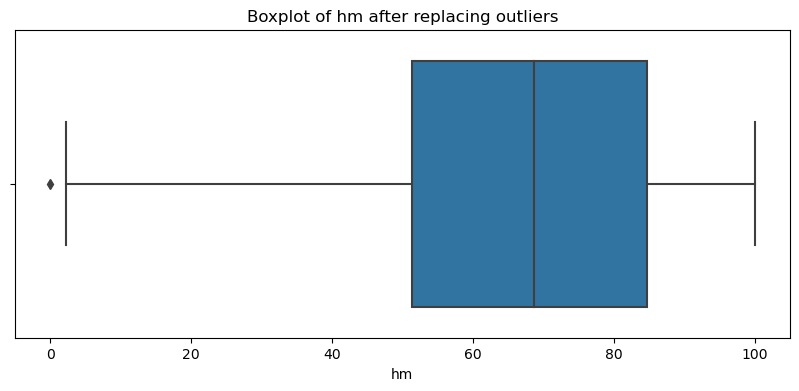

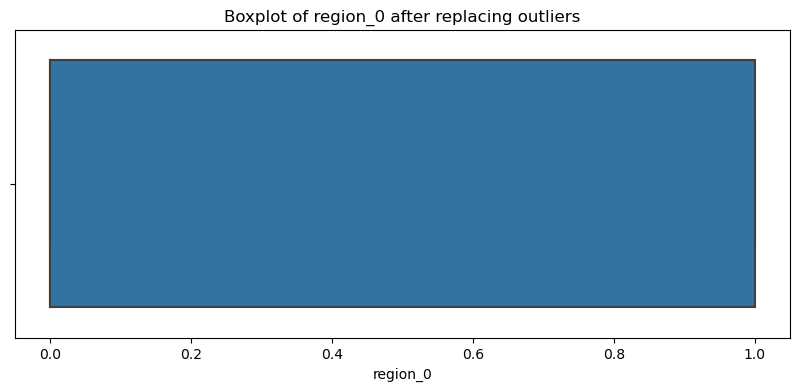

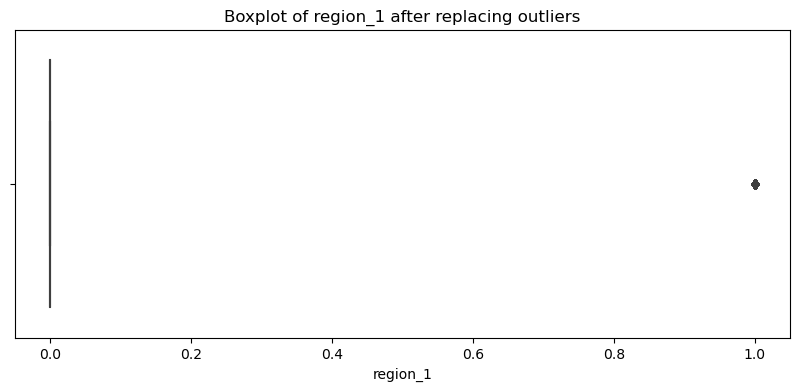

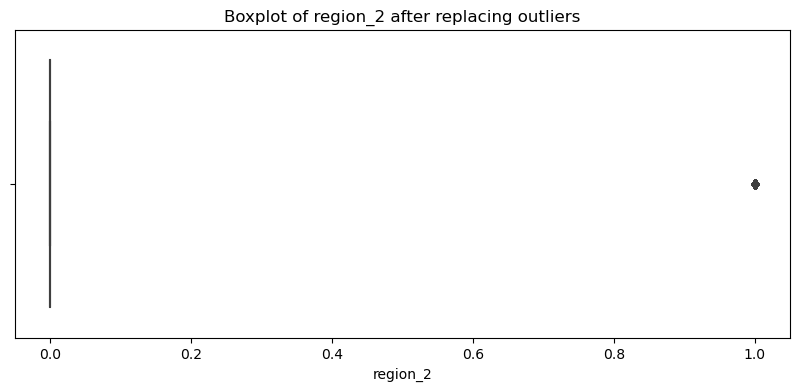

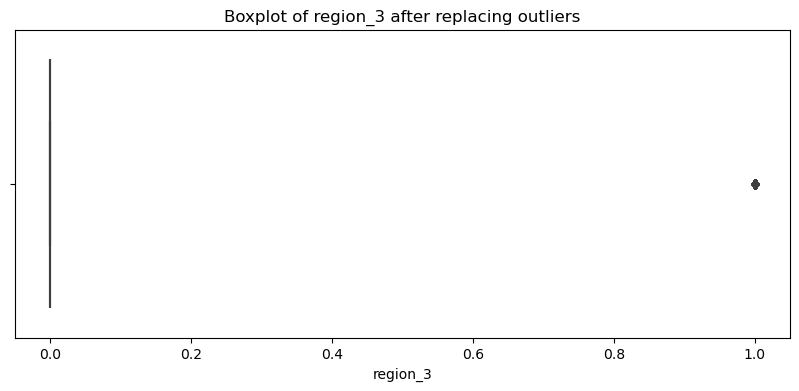

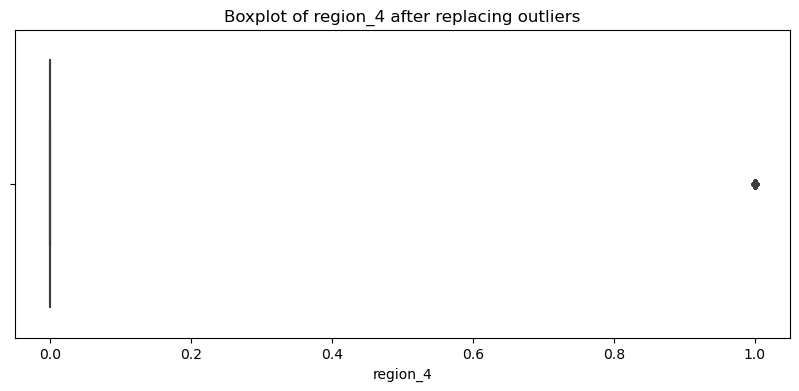

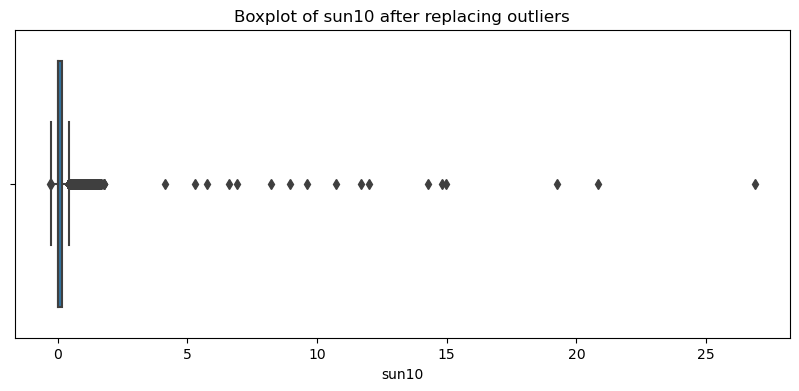

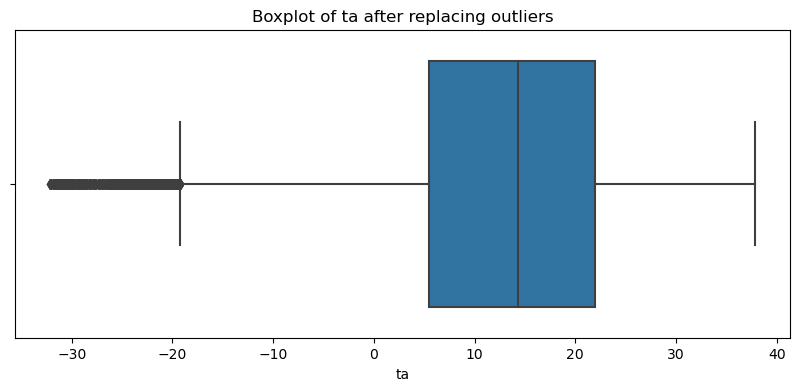

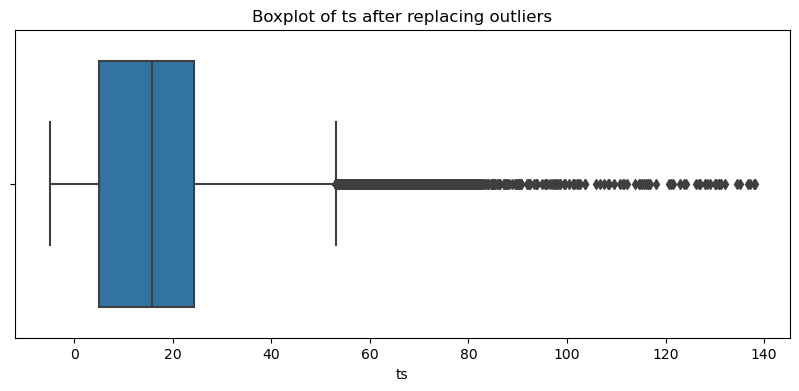

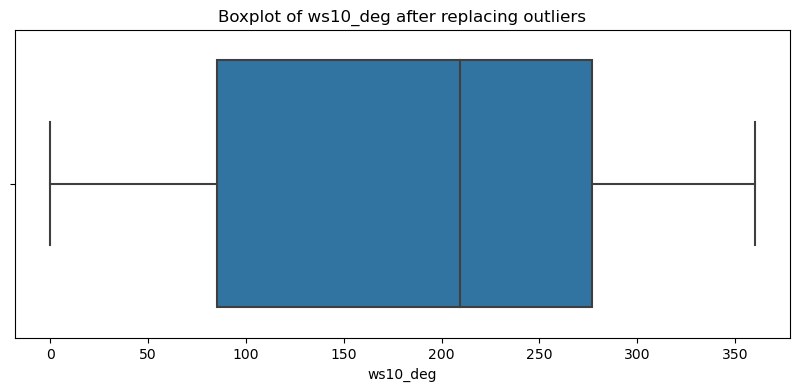

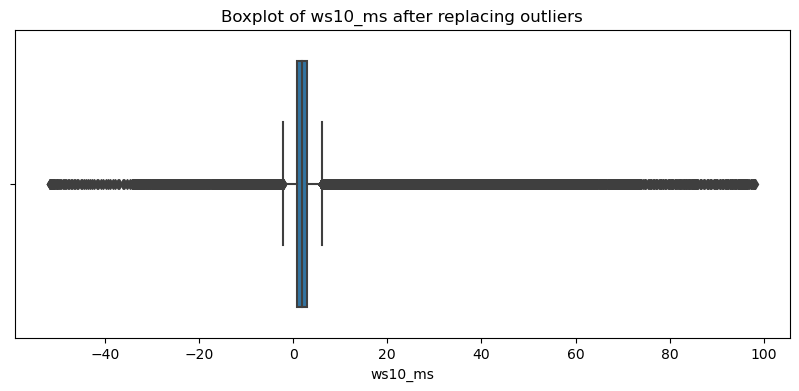

In [25]:
# 이상치 대체 후 시각화
for feature in features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature} after replacing outliers')
    plt.show()

# 5.정규화

## 5-1. 시간과 re열, target를 제외한 나머지의 데이터 정규화
> Min-Max, Standard, Robust 적용 후 비교

**1. Min-Max Scaler**

특징: 데이터 값을 0과 1 사이로 스케일링

적용 대상: 데이터가 정규 분포에 가깝고, 이상치가 적은 경우

장점: 모든 데이터가 동일한 범위로 스케일링되어 학습이 빠름

단점: 이상치에 매우 민감하며, 극단적인 값이 있을 경우 대부분의 데이터가 매우 좁은 범위로 압축될 수 있음

**2. Standard Scaler**

특징: 데이터의 평균을 0, 표준 편차를 1로 변환

적용 대상: 데이터가 정규 분포를 따르지 않고, 이상치가 적당히 존재하는 경우

장점: 평균과 분산이 고정된 데이터로 학습할 때 효과적

단점: 이상치가 있으면 평균과 표준 편차에 큰 영향을 줄 수 있음

**3. Robust Scaler**

특징: 중앙값을 0, IQR(Interquartile Range)를 사용하여 스케일링

적용 대상: 이상치가 많은 데이터에 적합

장점: 이상치의 영향을 크게 받지 않음

단점: 데이터의 중심이 중앙값으로 이동하므로, 데이터 분포의 비대칭성을 고려해야 함

## 5-2. Min-Max Scaler

In [26]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# features = df.columns.difference(['year', 'month', 'day', 'time', 'minute', 're', 'stn_id', 'vis1', 'class'])

# df[features] = scaler.fit_transform(df[features])
# df

## 5-2. Standard Scaler

In [27]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# features = df.columns.difference(['year', 'month', 'day', 'time', 'minute', 're', 'stn_id', 'vis1', 'class'])

# df[features] = scaler.fit_transform(df[features])
# df

## 5-3. Robust Scaler

In [28]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# features = df.columns.difference(['year', 'month', 'day', 'time', 'minute', 're', 'stn_id', 'vis1', 'class'])

# df[features] = scaler.fit_transform(df[features])
# df

# 6. class 결측치 채우기

## 6-1. XGR를 활용하여 vis1 결측값 예측한 후, 해당 예측값을 결측값을 대체

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# 데이터 복사
df_rfr = df.copy()

In [38]:
# class 분포 확인 함수
def count_classes(df):
    return df['class'].value_counts()

# 초기 class 분포
initial_class_counts = count_classes(df_rfr)

In [39]:
# 결측치가 아닌 행과 결측치인 행을 구분
train_data = df_rfr[df_rfr['vis1'] != -99]
test_data = df_rfr[df_rfr['vis1'] == -99]

# 제외할 열을 지정하여 feature 선택
features = df_rfr.columns.difference(['vis1', 'class'])

# 학습을 위한 feature와 target 분리
X_train = train_data[features]
y_train = train_data['vis1']
X_test = test_data[features]

# 데이터 스케일링
scaler = RobustScaler()
# 스케일링할 열을 선택합니다
features_to_scale = df_rfr.columns.difference(['year', 'month', 'day', 'time', 'minute', 're', 'stn_id', 'vis1', 'class'])
# 선택된 열에 대해 RobustScaler를 적용합니다
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train_scaled[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test_scaled[features_to_scale])

In [40]:
# 랜덤 포레스트 회귀 모델 학습 및 예측
rf_model = RandomForestRegressor(random_state=123)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# 예측된 값으로 vis1 결측치 대체
df_rfr.loc[df_rfr['vis1'] == -99, 'vis1'] = y_pred

In [ ]:
# 확인용
# print(y_pred.shape)
# print(df_xgr.loc[df_xgr['vis1'] == -99, 'vis1'].shape)
# print(test_data.shape)

In [ ]:
# class 분류 함수
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

# class가 -99인 행에 대해 vis1을 기반으로 class 값 분류
df_rfr.loc[df_rfr['class'] == -99, 'class'] = df_rfr.loc[df_rfr['class'] == -99, 'vis1'].apply(classify_visibility)

In [ ]:
# 예측된 vis1 값을 기반으로 한 class 분포
predicted_class_counts = df_rfr.loc[df_rfr['class'] != -99, 'class'].value_counts()
# 최종 class 분포
final_class_counts = count_classes(df_rfr)

# 각 class별 증가 수 계산
class_increase_counts = final_class_counts - initial_class_counts

# 결과 출력
print("Class increase counts:\n", class_increase_counts)

# 시각화
# y_pred 기반 class 분포 시각화
df_pred_class = pd.DataFrame({'y_pred': y_pred})
df_pred_class['pred_class'] = df_pred_class['y_pred'].apply(classify_visibility)

# 분포를 숫자로 표시한 막대 그래프
plt.figure(figsize=(12, 6))
sns.barplot(x=df_pred_class['pred_class'].value_counts().index, y=df_pred_class['pred_class'].value_counts().values)
plt.title('Distribution of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
# 막대 위에 숫자 표시
for index, value in enumerate(df_pred_class['pred_class'].value_counts().values):
    plt.text(index, value + 0.05, str(value), ha='center')

plt.show()

## 6-2. svm를 활용하여 vis1 결측값 예측한 후, 해당 예측값을 결측값을 대체

In [27]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [ ]:
# df_SVM는 class를 svm으로 채운 데이터 셋
df_SVM = df.copy()

In [ ]:
# 나중에 비교를 위한
# class 분포 확인 함수
def count_classes(df_SVM):
    return df_SVM['class'].value_counts()

# 초기 class 분포
initial_class_counts = count_classes(df_SVM)

In [ ]:
# SVM 회귀를 사용하여 vis1의 결측치 예측
# 결측치가 아닌 행과 결측치인 행을 구분
train_data = df_SVM[df_SVM['vis1'] != -99]
test_data = df_SVM[df_SVM['vis1'] == -99]

# 제외할 열을 지정하여 feature 선택
features = df_SVM.columns.difference(['vis1', 'class'])

# 학습을 위한 feature와 target 분리
X_train = train_data[features]
y_train = train_data['vis1']
X_test = test_data[features]

# SVM 회귀 모델 학습 및 예측
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

# 예측된 값으로 vis1 결측치 대체
df_SVM.loc[df_SVM['vis1'] == -99, 'vis1'] = y_pred  

In [ ]:
# class 분류 함수
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

# class가 -99인 행에 대해 vis1을 기반으로 class 값 분류
df_SVM.loc[df_SVM['class'] == -99, 'class'] = df_SVM.loc[df_SVM['class'] == -99, 'vis1'].apply(classify_visibility)

In [ ]:
# 최종 class 분포
final_class_counts = count_classes(df_SVM)

# 결과 출력
print("Initial class counts:\n", initial_class_counts)
print("Final class counts:\n", final_class_counts)

In [ ]:
# y_pred 살피면 몇 개씩 예측했는지 나올 듯 

## 6-3. 완성된 데이터 셋 저장

In [ ]:
import joblib

In [ ]:
# xgr

# 노트북
# joblib.dump(df_rfr, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_rfr.pkl')

# 데스크탑
joblib.dump(df_rfr, "C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_rfr.pkl")

['C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl']

In [ ]:
# svm

# 노트북
# joblib.dump(df_SVM, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_SVM.pkl')

# 데스크탑
# joblib.dump(df_SVM, "C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_SVM.pkl")


In [ ]:
# 이후는 모델 예측

# 7. CLASS 예측(분류)

## 7-1. RNN

In [ ]:
df2

,year,month,day,time,minute,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,stn_id_5
0,0,1,1,0,10,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4,0
1,0,1,1,0,20,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4,0
2,0,1,1,0,30,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4,0
3,0,1,1,0,40,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4,0
4,0,1,1,0,50,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,2,12,31,23,10,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4,4
3156455,2,12,31,23,20,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4,4
3156456,2,12,31,23,30,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4,4
3156457,2,12,31,23,40,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4,4


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import seaborn as sns

In [ ]:
# 특성과 타겟 정의
features = df2.drop(['class'], axis=1).values.astype('float32')
target = df2['class'].values

# 타겟 원-핫 인코딩
target_encoded = to_categorical(target - 1)  # assuming class labels are 1 to 4

# 데이터 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.float32)

# 시퀀스 길이 정의
sequence_length = 4320  # 1달을 기준으로 30개 타임스텝을 사용

In [ ]:
# 시퀀스 데이터 생성
X, y = create_sequences(features_scaled, target_encoded, sequence_length)

# 학습 데이터와 테스트 데이터 분리
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

MemoryError: Unable to allocate 626. GiB for an array with shape (2990530, 4320, 13) and data type float32

In [50]:
from tensorflow.keras.metrics import Precision, Recall

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, X.shape[2]), return_sequences=False))
model.add(Dense(4, activation='softmax'))  # 다중 분류를 위한 softmax 활성화 함수

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# 얼리스타핑 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1, # 로그출력
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

NameError: name 'Sequential' is not defined

18718/18718 [==============================] - 86s 5ms/step
Balanced Accuracy: 0.24999957803058434


c:\Users\Hong_PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hong_PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hong_PC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1663
           1       0.00      0.00      0.00      2689
           2       0.00      0.00      0.00      2152
           3       0.99      1.00      0.99    592460

    accuracy                           0.99    598964
   macro avg       0.25      0.25      0.25    598964
weighted avg       0.98      0.99      0.98    598964



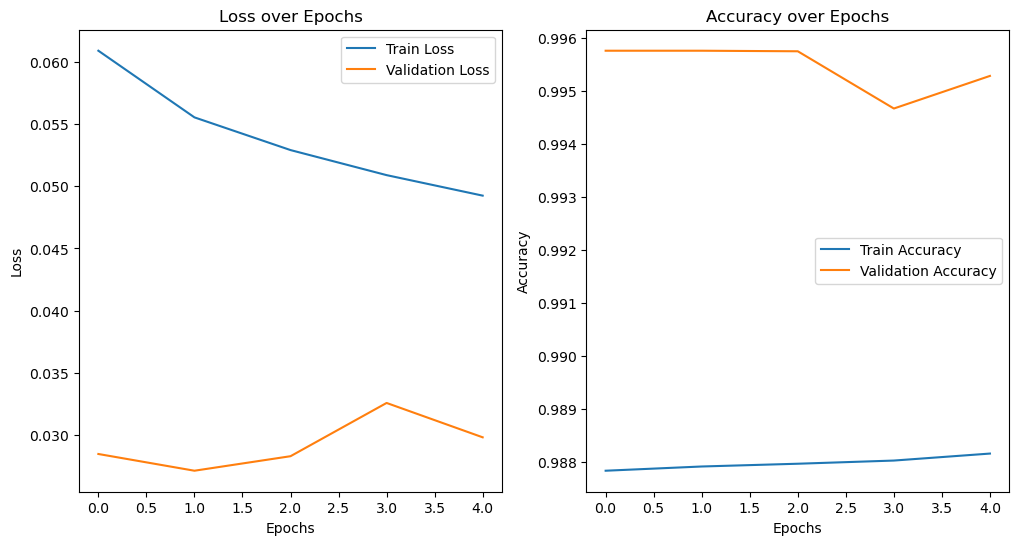

In [ ]:
# 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# balanced accuracy 계산
balanced_acc = balanced_accuracy_score(y_true_classes, y_pred_classes)
print(f'Balanced Accuracy: {balanced_acc}')

# 분류 보고서 출력
print(classification_report(y_true_classes, y_pred_classes))

# CSI 반영
y_true = y_true_classes

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# ACC 및 Balanced ACC 계산
acc = accuracy_score(y_true, y_pred_classes)
balanced_acc = balanced_accuracy_score(y_true, y_pred_classes)

# CSI 계산
H = np.diag(conf_matrix)
F = np.sum(conf_matrix, axis=0) - H
M = np.sum(conf_matrix, axis=1) - H
CSI = np.where((H + F + M) != 0, H / (H + F + M), 0)  # 분모가 0이 되는 것을 방지
mean_CSI = np.mean(CSI)

# 결과 출력
print(f'Accuracy: {acc}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'CSI per class: {CSI}')
print(f'Mean CSI: {mean_CSI}')

In [ ]:
# 학습 및 검증 손실 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 혼동 행렬 그래프
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## 7-2. RF

# 8. VIS1 예측(회귀)

In [33]:
df = df_rfr.copy()

In [39]:
print(df[(df['vis1']!='2000')].shape)
print(df[(df['vis1']=='2000')].shape)

(3156459, 15)
(0, 15)


**파생변수** 

In [52]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,dew_point,season
1,0,1,1,0,10,0,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4,-18.083476,3
2,0,1,1,0,20,0,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4,-18.299136,3
3,0,1,1,0,30,0,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4,-17.664937,3
4,0,1,1,0,40,0,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4,-17.722897,3
5,0,1,1,0,50,0,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4,-17.543307,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156455,2,12,31,23,10,4,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4,-6.810493,3
3156456,2,12,31,23,20,4,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4,-7.021146,3
3156457,2,12,31,23,30,4,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4,-6.882689,3
3156458,2,12,31,23,40,4,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4,-6.798347,3


In [51]:
# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)

In [ ]:
# 이슬점(dew_point)

import math

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    # 상대 습도가 0이면 매우 낮은 값을 설정하여 log(0)가 발생하지 않도록 한다.
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

# 이슬점 계산하여 새로운 열 추가
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
# 될지 모르겠다.
# 새벽 4-8시의 평균 이슬점
'''
# minute이 4, 5, 6, 7, 8인 데이터를 필터링하여 평균 dew_point 계산
avg_dew_point = df[df['minute'].isin([4, 5, 6, 7, 8])].groupby(['year', 'month', 'day', 'stn_id'])['dew_point'].mean()
avg_dew_point = avg_dew_point.reset_index()

# 기존 데이터프레임에 평균 dew_point 열을 병합
df = pd.merge(df, avg_dew_point, on=['year', 'month', 'day', 'stn_id'], how='left', suffixes=('', '_avg'))
'''

In [ ]:
# 풍향
# 풍향을 16방위로 변환하는 함수
def convert_wind_direction(wind_dir):
    # 22.5도 간격으로 16방위로 매핑
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction



In [ ]:
# 일교차(diurnal_range)
# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

# 풍향을 16방위로 변환하여 새로운 열에 추가
df['wind_direction_16'] = df['wind_direction'].apply(convert_wind_direction)

# 원-핫 인코딩을 위해 더미 변수 생성
df = pd.get_dummies(df, columns=['wind_direction_16'], prefix='wind_dir')

In [ ]:
# 이동평균

In [ ]:
# 필요 없는 열 제거(시간 디테일 지역이라던가)

## 8-1. LSTM-1(양방향)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 필요한 열만 사용
features = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts'] # 수정 필요
target = 'vis1'
data = df[features + [target]]

# 데이터 정규화 # 수정 필요
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [ ]:
# 시계열 데이터 생성
sequence_length = 6

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length][target]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data.values, sequence_length)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=123)

In [ ]:
# 양방향 LSTM 모델 구성
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))  # Dropout 추가
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stopping])

In [ ]:
# history 그래프로 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 모델 평가
y_pred = model.predict(X_test)

# 예측된 vis1을 바탕으로 class를 계산
def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred])
y_test_class = np.array([classify_vis1(vis) for vis in y_test])

In [ ]:
# CSI 계산 예시 (필요에 따라 추가적으로 수행)
from sklearn.metrics import confusion_matrix

def calculate_csi(y_true, y_pred):
    confusion = confusion_matrix(y_true, y_pred)
    csi = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1] + confusion[1, 0])
    return csi

csi = calculate_csi(y_test_class, y_pred_class)
print(f'CSI: {csi}')

### fog_test.csv을 예측 

In [ ]:
# 데스크탑
df_test = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

# 노트북
# df_test = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

In [ ]:
# 필요한 열만 사용
features = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts'] # 수정필요
target = 'vis1'
data_test = df_test[features]

# 데이터 정규화 # 수정필요
scaler = MinMaxScaler()
data_test[features] = scaler.fit_transform(data_test[features])


In [ ]:
# # 시계열 데이터 생성 (필요 시)
# sequence_length = 6

# def create_sequences(data, sequence_length):
#     sequences = []
#     for i in range(len(data) - sequence_length + 1):
#         seq = data[i:i + sequence_length]
#         sequences.append(seq)
#     return np.array(sequences)

# sequences_test = create_sequences(data_test.values, sequence_length)

In [ ]:
# 모델 예측
y_pred = model.predict(sequences_test)

# 예측된 vis1을 바탕으로 class를 계산
def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_class = np.array([classify_vis1(vis) for vis in y_pred])

# 예측 결과를 DataFrame에 추가
df_test['predicted_class'] = y_pred_class

# 예측 결과 출력 또는 저장 (필요에 따라)
print(df_test[['year', 'month', 'day', 'time', 'predicted_class']])

## 8-2. LSTM-2(옛날)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, balanced_accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [ ]:
# 특성과 타겟 정의
features = df.drop(['class', 'vis1'], axis=1).values.astype('float32')
target = df['vis1'].values.astype('float32')

# 데이터 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.reshape(-1, 1)).flatten()

In [ ]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(target[i + sequence_length])
    return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.float32)

# 시퀀스 길이 정의
sequence_length = 30  # 1달을 기준으로 30개 타임스텝을 사용

In [ ]:
# 시퀀스 데이터 생성
X, y = create_sequences(features_scaled, target_scaled, sequence_length)

# 학습 데이터와 테스트 데이터 분리
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# LSTM 회귀 모델 정의
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, X.shape[2]), return_sequences=False))
model.add(Dense(1))  # 회귀를 위한 단일 출력 뉴런

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 얼리스타핑 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1, 
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# 학습 결과 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Epoch 1/50
29949/29949 [==============================] - 755s 25ms/step - loss: 0.0216 - val_loss: 0.0398
Epoch 2/50
29949/29949 [==============================] - 864s 29ms/step - loss: 0.0193 - val_loss: 0.0469
Epoch 3/50
29949/29949 [==============================] - 824s 28ms/step - loss: 0.0181 - val_loss: 0.0462
Epoch 4/50
 7549/29949 [======>.......................] - ETA: 8:05 - loss: 0.0176

In [ ]:
# 예측
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 예측된 vis1 값을 기반으로 클래스 분류
def classify_vis1(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

y_pred_classes = np.array([classify_vis1(vis) for vis in y_pred_rescaled])
y_true_classes = np.array([classify_vis1(vis) for vis in y_test_rescaled])

In [ ]:
# balanced accuracy 계산
balanced_acc = balanced_accuracy_score(y_true_classes, y_pred_classes)
print(f'Balanced Accuracy: {balanced_acc}')

# 분류 보고서 출력
print(classification_report(y_true_classes, y_pred_classes))

# 학습 결과 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test_rescaled)), y_test_rescaled, label='True vis1')
plt.scatter(range(len(y_pred_rescaled)), y_pred_rescaled, label='Predicted vis1')
plt.title('True vs Predicted vis1')
plt.xlabel('Sample Index')
plt.ylabel('vis1')
plt.legend()

plt.show()

#### RF